# Importing Libraries

In [1]:
# if using tpu then run this(this block will be used for showing tpu logs)
import os
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tpu=1
import sys
sys.stderr = open(os.devnull, 'w')

In [2]:
from matplotlib import pyplot as plt  # Displaying images
from skimage.io import imread         # Read the images
import numpy as np                    # Data Handling
import datetime                       # Used in Naming
import math                           # Math operations
import os                             # Directory files
import pandas as pd
# One Hot Encoded Mask and Dataset Building
from tensorflow.keras.utils import to_categorical, Sequence
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import glob
import cv2

# Creating and preprocessing the data

In [3]:
# Set the root directory paths for images and masks
img_dir = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/render'
mask_dir = '/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean'

# Sort the files in root directories, Create and Store the complete image and mask paths
images = [os.path.join(img_dir, x) for x in sorted(os.listdir(img_dir))]
masks = [os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir))]


# First 8000 images to be used for training
X_train = images[:8000]
y_train = masks[:8000]

# Remaining can be used for validation purpose
X_valid = images[8000:-100]
y_valid = masks[8000:-100]

# Save some for testing purpose (last 4)
X_test = images[-100:]
y_test = masks[-100:]

## Loading a random image and preprocessing it (for experimentation)

Mask Preprocessing

In [3]:
mask_sample_path = str(y_train[np.random.randint(len(y_train))])

print(mask_sample_path)

/kaggle/input/artificial-lunar-rocky-landscape-dataset/images/clean/clean4923.png


In [123]:
# Read the mask as greyscale
img = tf.io.read_file(mask_sample_path)
sample_mask_arr = tf.io.decode_png(img,channels=1)
# Remove the last dimension to get a 2D array (height, width)
#sample_mask_arr = tf.squeeze(sample_mask_arr, axis=-1)
print(sample_mask_arr.shape)

(480, 720, 1)


In [124]:
#sample_mask_arr = tf.expand_dims(sample_mask_arr, axis=-1) #used to add one more dimension
sample_mask_cropped = tf.image.resize(sample_mask_arr,(480,480), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
sample_mask_cropped = tf.squeeze(sample_mask_cropped, axis=-1)
print(sample_mask_cropped.shape)

(480, 480)


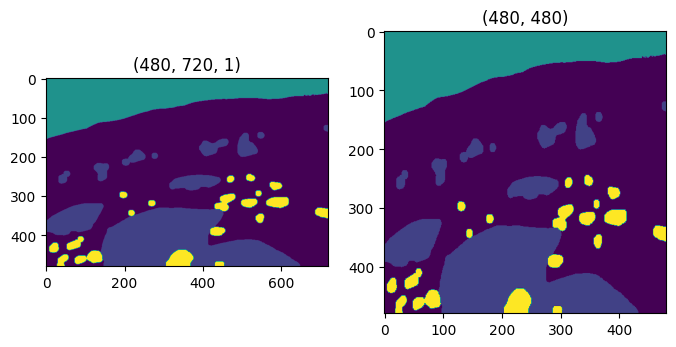

In [132]:
# Mask with original size and after cropping
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_data = ((sample_mask_arr, sample_mask_cropped),
            (sample_mask_arr.shape, sample_mask_cropped.shape))

for (ax, arr, title) in zip(axes,*(plot_data)) :
    ax.imshow(arr)
    ax.set_title(title)


In [133]:
# Check the unique values in cropped_mask
sample_mask_cropped = tf.cast(sample_mask_cropped, tf.int32)
np.unique(sample_mask_cropped)

array([  0,  29,  76, 149], dtype=int32)

In [134]:
np.unique(sample_mask_cropped)//29

array([0, 1, 2, 5], dtype=int32)

In [135]:
# We need to convert the values of 5 to 3 after floor operation with 29
adjusted_mask = sample_mask_cropped//29
# Replace all values of 5 with 3
adjusted_mask = tf.where(adjusted_mask == 5, 3, adjusted_mask)
print(np.unique(adjusted_mask))

[0 1 2 3]


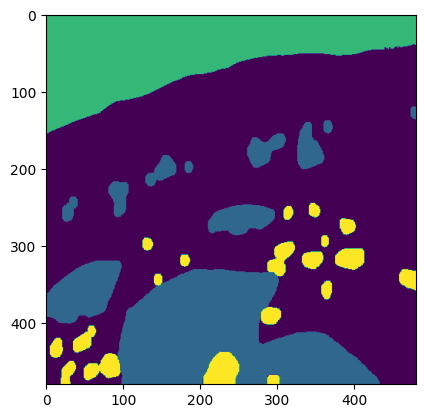

In [136]:
plt.imshow(adjusted_mask)

In [137]:
# Get 4 channel one hot encoded mask
final_sample_mask = to_categorical(adjusted_mask,num_classes=4)
#final_sample_mask = tf.one_hot(adjusted_mask, depth=4)
final_sample_mask

<tf.Tensor: shape=(480, 480, 4), dtype=float32, numpy=
array([[[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       ...,

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]],

       [[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],

In [138]:
final_sample_mask.shape

TensorShape([480, 480, 4])

In [139]:
int_encoded_mask = np.argmax(final_sample_mask, axis=-1) # Get the index of the maximum value along the last axis to reduce dimensionality
int_encoded_mask

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [140]:
np.unique(int_encoded_mask)

array([0, 1, 2, 3])

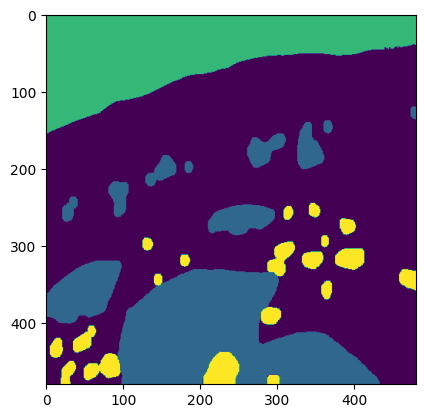

In [141]:
plt.imshow(int_encoded_mask)

## Creating Dataset Pipeline

In [4]:
def dataset_pipeline(X_set,y_set,batch_size,target_size,shuffle=True,augment=False,cache=False,temp_dir=None):
    
    def img_path_gen(X_set,y_set):
        for x,y in zip(X_set,y_set):
            yield x,y
    
   
        
    
    def preprocess_image(x,y,target_size):
        # preprocessing input images
        img = tf.io.read_file(x)
        img = tf.io.decode_png(img, channels=3)
        img = tf.image.resize(img,target_size)
        img = tf.cast(img, tf.float32) / 255.0
        
        mask = tf.io.read_file(y)
        mask = tf.io.decode_png(mask,channels=1)
        mask = tf.image.resize(mask,target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask = tf.squeeze(mask, axis=-1)
        mask = tf.cast(mask, tf.int32)
        mask = mask//29
        mask = tf.where(mask == 5, 3, mask) #if cond is true then will put 3 on that index else mask's original value
        mask = to_categorical(mask, num_classes = 4)
        
        return img,mask
        
    def augment_image(x,y):
        
        if tf.random.uniform(()) > 0.5: #from uniform distribution graph, generates a random number between 0 and 1
            x = tf.image.flip_left_right(x)
            y = tf.image.flip_left_right(y)
            x = tf.image.flip_up_down(x)
            y = tf.image.flip_up_down(y)
            x = tf.image.rot90(x)
            y = tf.image.rot90(y)
            x = tf.image.adjust_brightness(x, 0.1)
        
        
        
        return x, y
    
        
    dataset = tf.data.Dataset.from_generator(
        lambda: img_path_gen(X_set, y_set),
        output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(), dtype=tf.string))
    )
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X_set))
    
    dataset = dataset.map(
    lambda x,y : preprocess_image(x,y,target_size), num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    
    
    if cache:
        if temp_dir != None:
            dataset = dataset.cache(temp_dir)
        else: 
            dataset = dataset.cache()
    
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Batch the dataset
    dataset = dataset.batch(batch_size)
    #dataset = dataset.repeat()
    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [5]:
batch_size_gpu=16
batch_size_tpu=16
target_size=(480,480)
temp_dir = "/kaggle/temp"
os.makedirs(temp_dir, exist_ok=True)

In [6]:
# for experimentation
train_dataset = dataset_pipeline(X_train,y_train, batch_size_gpu, target_size, shuffle=True, augment=False, cache=False,temp_dir=None)
batch = next(iter(train_dataset))
print(batch[0].shape) 
print(batch[1].shape)

(16, 480, 480, 3)
(16, 480, 480, 4)


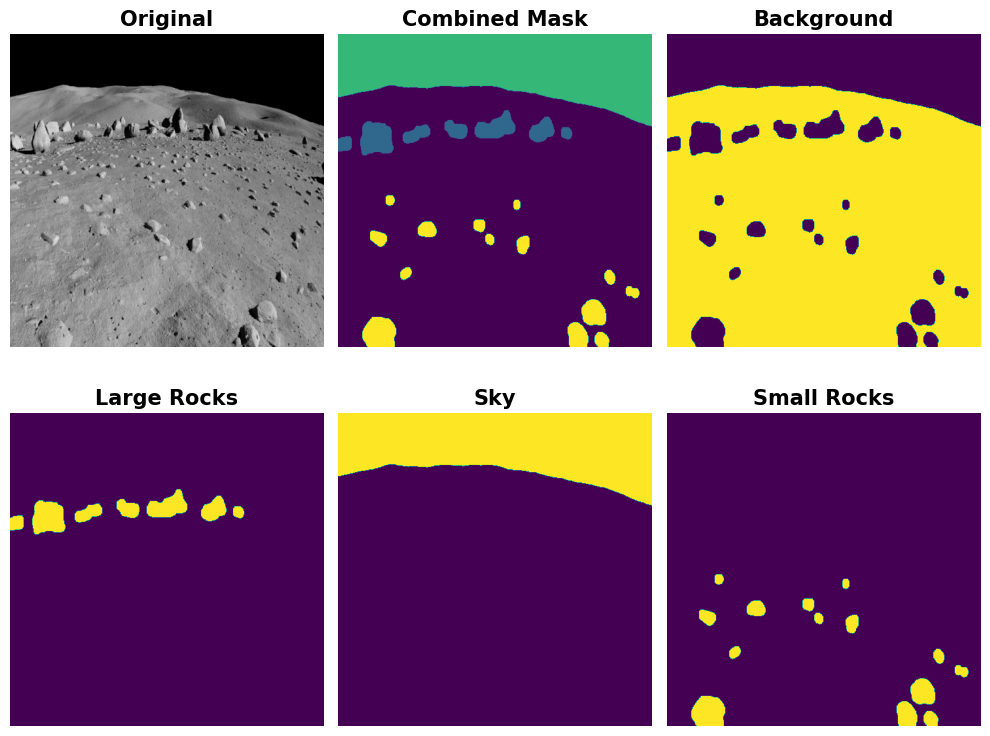

In [7]:
# Get the mask
sample = batch[1][1] # Second in the batch
# Creating Subplot for better visualization
fig, ((a1, a2, a3), (a4, a5, a6)) = plt.subplots(2, 3, figsize = (10, 8))

# For different axes and titles
for i, (ax,title) in enumerate(zip((a1, a2, a3, a4, a5, a6),
                                   ('Original', 'Combined Mask', 'Background', 'Large Rocks', 'Sky', 'Small Rocks'))):
    if i == 0:
        ax.imshow(batch[0][1])                    # Second Image in the batch (Original)
    elif i == 1:
        ax.imshow(np.argmax(sample, axis=-1))     # Converts One Hot encoded mask to Integer Encoded Mask (single channel)
    else:
        ax.imshow(sample[:, :, i-2])              # Channel Wise Output from Mask

    # Set Title and turn off the axis
    ax.set_title(title, fontsize=15, weight='bold')
    ax.axis('off')

# Adjust Layout and Display the Subplot
plt.tight_layout()
plt.show()

In [6]:
import tensorflow as tf

# Check if GPUs are available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Memory growth enabled for GPUs


In [7]:
tf.keras.backend.clear_session()


In [8]:
if tf.config.list_physical_devices('GPU'):
    gpu_strategy = tf.distribute.MirroredStrategy()
    with gpu_strategy.scope():

        train_dataset = dataset_pipeline(X_train,y_train, batch_size_gpu, target_size, shuffle=True, augment=False, cache=True,temp_dir="/kaggle/temp/train")
        dev_dataset = dataset_pipeline(X_valid,y_valid, batch_size_gpu, target_size, shuffle=False, augment=False, cache=False,temp_dir="/kaggle/temp/dev")
        test_dataset = dataset_pipeline(X_test,y_test, batch_size_gpu, target_size, shuffle=False, augment=False, cache=False ,temp_dir="/kaggle/temp/test")
        
        train_dataset = gpu_strategy.experimental_distribute_dataset(train_dataset)
        dev_dataset = gpu_strategy.experimental_distribute_dataset(dev_dataset)
        test_dataset = gpu_strategy.experimental_distribute_dataset(test_dataset)
        
        

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    if tpu==1:
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        tpu=0
    tpu_strategy = tf.distribute.TPUStrategy(resolver)
    print("All TPU devices: ", tf.config.list_logical_devices('TPU'))
    
    with tpu_strategy.scope():
        train_dataset = dataset_pipeline(X_train,y_train, batch_size_tpu, target_size, shuffle=True, augment=False, cache=True)
        dev_dataset = dataset_pipeline(X_valid,y_valid, batch_size_tpu, target_size, shuffle=False, augment=False, cache=True)
        test_dataset = dataset_pipeline(X_test,y_test, batch_size_tpu, target_size, shuffle=False, augment=False, cache=False)
        
        train_dataset = tpu_strategy.experimental_distribute_dataset(train_dataset)
        dev_dataset = tpu_strategy.experimental_distribute_dataset(dev_dataset)
        test_dataset = tpu_strategy.experimental_distribute_dataset(test_dataset)
except (ValueError, tf.errors.NotFoundError) as e:
    print(f"No TPU found or initialization failed: {e}. Skipping TPU training.")

No TPU found or initialization failed: Please provide a TPU Name to connect to.. Skipping TPU training.


# Segmentation Model

In [9]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [10]:
os.environ["SM_FRAMEWORK"] = "tf.keras" 
import segmentation_models as sm 
sm.set_framework('tf.keras')            # Use segmentation_models library and set the framework to TensorFlow's Keras

Segmentation Models: using `tf.keras` framework.


In [11]:
# Set the last axis of the tensor as channel axis
tf.keras.backend.set_image_data_format('channels_last')
# Explicitly setting this is not always necessary, as 'channels_last' is the default setting

In [13]:
import segmentation_models as sm
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, Dropout, LeakyReLU, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy



def apply_l2_regularization(model, l2_strength):
    """Apply L2 regularization to all Conv2D layers in the model."""
    for layer in model.layers:
        if isinstance(layer, (Conv2D,Conv2DTranspose)):
            layer.kernel_regularizer = l2(l2_strength)
    #new_model = tf.keras.models.clone_model(model)
    #new_model.set_weights(model.get_weights())
    return model



def create_model():
    # Parameters
    BACKBONE = 'vgg16'
    input_shape = (480, 480, 3)
    n_classes = 4
    activation = 'softmax'
    l2_strength = 1e-4
  
    # Base UNet model with frozen encoder
    model = sm.Unet(
        backbone_name=BACKBONE,
        input_shape=input_shape,
        classes=n_classes,
        activation=activation,
        encoder_weights='imagenet'
        #encoder_freeze=True
    )
    
  
       
    
    #model = apply_l2_regularization(model, l2_strength)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    #optimizer = Adam(learning_rate=1e-5, epsilon=1e-8, decay=1e-6)
    optimizer = AdamW(learning_rate=1e-5, weight_decay=1e-6)

    def combined_loss(y_true, y_pred):
        jaccard_loss = sm.losses.JaccardLoss()(y_true, y_pred)
        dice_loss = sm.losses.DiceLoss()(y_true, y_pred)
        categorical_crossentropy_loss = CategoricalCrossentropy()(y_true, y_pred)
        return 0.3 * jaccard_loss + 0.2 * dice_loss + 0.5 * categorical_crossentropy_loss 

    #optimizer = tf.keras.optimizers.RMSprop(1e-5)
    # compiling the model --> Try changing the loss function to jacard_loss from sm library and see changes!
    model.compile(loss = combined_loss,
                  optimizer = optimizer,
                  metrics = metrics)
    
    return model





In [14]:
if tf.config.list_physical_devices('GPU'):
    with gpu_strategy.scope():
        model= create_model()

if tf.config.list_logical_devices('TPU'):
    with tpu_strategy.scope():
        model= create_model()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
#model.load_weights('/kaggle/working/models/LunarModel.keras')

In [21]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 480, 480,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 480, 480,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 480, 480,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 240, 240,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 240, 240,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 240, 240,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 120, 120,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 120, 120,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 120, 120,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 120, 120,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 60, 60,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 60, 60,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 60, 60,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 60, 60,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 30, 30,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 30, 30,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 30, 30,    │  2,359,808 │ block5_conv1[0][

 Total params: 23,752,708 (90.61 MB)

 Trainable params: 23,748,676 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [16]:
results_df = pd.DataFrame(columns=['Changes Made', 'Train IOUScore', 'Dev IOUScore', 'Test IOUScore'])


In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import callbacks

callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/LunarModel.keras', monitor='val_iou_score', verbose=1, mode='max', save_best_only=True), # Create a callback that saves the model periodically as training moves along the number of epochs.
             
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6), #This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
                         
             
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max'),  #Stop training when a monitored metric has stopped improving.
]

In [18]:
def record_results(changes_description, train_iou, dev_iou, test_iou, epochs):
    """
    Function to append results to the DataFrame with a concise description.
    """
    global results_df
    concise_description = (
        f"Changes: {changes_description}, "
        f"Epochs: {epochs}"
    )
    
    # Create a new DataFrame row
    new_row = pd.DataFrame({
        'Changes Made': [concise_description],
        'Train IOUScore': [train_iou],
        'Dev IOUScore': [dev_iou],
        'Test IOUScore': [test_iou]
    })

    # Concatenate the new row with the existing DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)


In [ ]:
if tf.config.list_physical_devices('GPU'):
    changes_description = "(Used GPU)backbone='vgg16',finetuning=True(not freezing the layers) , batch size = 16, loss_fn='categorical_crossentropy+jaccardloss+diceloss', initial_lr=1e-5(adamw), callbacks"

    with gpu_strategy.scope():
   
        history = model.fit(train_dataset, validation_data=dev_dataset,epochs=30,callbacks=callbacks)

        # Fetch the last epoch iou for train and dev from history
        last_train_iou = history.history['iou_score'][-1]
        last_dev_iou = history.history['val_iou_score'][-1]

        # Evaluate on the test set
        test_iou = model.evaluate(test_dataset, verbose=0)[1]  

        # Record the results
        record_results(changes_description, last_train_iou, last_dev_iou, test_iou, 30)


if tf.config.list_logical_devices('TPU'):
    with tpu_strategy.scope():
     
        changes_description = "(Used Tpu)backbone='resnet34',finetuning=True(not freezing the layers), batch size = 16, loss_fn='categorical_crossentropy+jaccardloss+diceloss', initial_lr=5e-5(adamw), callbacks,before last layer adding spatial dropout"
        history = model.fit(train_dataset,validation_data=dev_dataset, epochs=30,callbacks=callbacks)

        # Fetch the last epoch iou for train and dev from history
        last_train_iou = history.history['iou_score'][-1]
        last_dev_iou = history.history['val_iou_score'][-1]

        # Evaluate on the test set
        test_iou = model.evaluate(test_dataset, verbose=0)[1]  

        # Record the results
        record_results(changes_description, last_train_iou, last_dev_iou, test_iou, 30)
# Display the DataFrame
print(results_df)
    

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - f1-score: 0.2547 - iou_score: 0.1958 - loss: 0.9539
Epoch 1: val_iou_score improved from -inf to 0.36146, saving model to models/LunarModel.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 468s 910ms/step - f1-score: 0.2549 - iou_score: 0.1960 - loss: 0.9537 - val_f1-score: 0.4257 - val_iou_score: 0.3615 - val_loss: 0.7120 - learning_rate: 1.0000e-05
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - f1-score: 0.4718 - iou_score: 0.4159 - loss: 0.6332
Epoch 2: val_iou_score improved from 0.36146 to 0.53350, saving model to models/LunarModel.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 452s 905ms/step - f1-score: 0.4719 - iou_score: 0.4160 - loss: 0.6331 - val_f1-score: 0.6048 - val_iou_score: 0.5335 - val_loss: 0.5354 - learning_rate: 1.0000e-05
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - f1-score: 0.6595 - iou_score: 0.5810 - loss: 0.4966
Epoch 3: val_iou_score improved from 0.53350 to 0.71642, saving model to models/LunarModel.keras
50

traning got freezed

In [38]:
if tf.config.list_physical_devices('GPU'):
    changes_description = "(Used GPU)backbone='vgg16',finetuning=True(not freezing the layers) , batch size = 16, loss_fn='categorical_crossentropy+jaccardloss+diceloss', initial_lr=1e-5(adamw), callbacks"

    with gpu_strategy.scope():

        history = model.fit(train_dataset, validation_data=dev_dataset, epochs=20,callbacks=callbacks)

        # Fetch the last epoch iou for train and dev from history
        last_train_iou = history.history['iou_score'][-1]
        last_dev_iou = history.history['val_iou_score'][-1]

        # Evaluate on the test set
        test_iou = model.evaluate(test_dataset, verbose=0)[1]  

        # Record the results
        record_results(changes_description, last_train_iou, last_dev_iou, test_iou, 30)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - f1-score: 0.8955 - iou_score: 0.8276 - loss: 0.1636
Epoch 1: val_iou_score improved from -inf to 0.80459, saving model to models/LunarModel.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 470s 915ms/step - f1-score: 0.8955 - iou_score: 0.8276 - loss: 0.1636 - val_f1-score: 0.8785 - val_iou_score: 0.8046 - val_loss: 0.1658 - learning_rate: 1.0000e-05
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - f1-score: 0.9006 - iou_score: 0.8346 - loss: 0.1471
Epoch 2: val_iou_score improved from 0.80459 to 0.81051, saving model to models/LunarModel.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 457s 915ms/step - f1-score: 0.9006 - iou_score: 0.8346 - loss: 0.1471 - val_f1-score: 0.8831 - val_iou_score: 0.8105 - val_loss: 0.1553 - learning_rate: 1.0000e-05
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - f1-score: 0.9077 - iou_score: 0.8444 - loss: 0.1333
Epoch 3: val_iou_score improved from 0.81051 to 0.81249, saving model to models/LunarModel.keras
50

KeyboardInterrupt: 

In [19]:
if tf.config.list_physical_devices('GPU'):
    changes_description = "(Used GPU)backbone='vgg16',finetuning=True(not freezing the layers) , batch size = 16, loss_fn='categorical_crossentropy+jaccardloss+diceloss', initial_lr=1e-5(adamw), callbacks"

    with gpu_strategy.scope():

        history = model.fit(train_dataset, validation_data=dev_dataset, epochs=1,callbacks=callbacks)

        # Fetch the last epoch iou for train and dev from history
        last_train_iou = history.history['iou_score'][-1]
        last_dev_iou = history.history['val_iou_score'][-1]

        # Evaluate on the test set
        test_iou = model.evaluate(test_dataset, verbose=0)[1]  

        # Record the results
        record_results(changes_description, last_train_iou, last_dev_iou, test_iou, 21)

    500/Unknown 482s 858ms/step - f1-score: 0.9173 - iou_score: 0.8584 - loss: 0.1099
Epoch 1: val_iou_score improved from -inf to 0.81817, saving model to models/LunarModel.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 517s 927ms/step - f1-score: 0.9173 - iou_score: 0.8584 - loss: 0.1099 - val_f1-score: 0.8863 - val_iou_score: 0.8182 - val_loss: 0.1369 - learning_rate: 1.0000e-05


In [20]:
# Define the file path for saving the results
file_path = 'model_results.csv'

# Check if the file already exists
file_exists = os.path.isfile(file_path)

# Save or append to the CSV file
results_df.to_csv(file_path, mode='a', header=not file_exists, index=False)

In [21]:
file_path='/kaggle/working/model_results.csv'
results_df= pd.read_csv(file_path)
results_df = results_df.drop_duplicates()
results_df = results_df.reset_index(drop=True)

In [23]:
from IPython.display import display
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(results_df.loc[[0,1,2,20,21,27]])
    

,Changes Made,Train IOUScore,Dev IOUScore,Test IOUScore
0,"Changes: (Used Tpu)backbone='resnet50',finetuning=True ,batch size = 16*8, loss_fn='JaccardLoss' , Epochs: 10",0.725830,0.436655,0.425355
1,"Changes: (Used Tpu)backbone='resnet50',finetuning=True ,batch size = 16*8, loss_fn='JaccardLoss' , Epochs: 30",0.793730,0.758600,0.719569
2,"Changes: (Used Tpu)backbone='resnet50',finetuning=True ,batch size = 16*8, loss_fn='JaccardLoss' , Epochs: 50",0.821934,0.766842,0.696543
20,"Changes: (Used Tpu)backbone='vgg16',finetuning=True(not freezing the layers) , batch size = 16, loss_fn='categorical_crossentropy+jaccardloss+diceloss', initial_lr=1e-5, applied l2(1e-2),added resule_lr, Epochs: 10",0.765616,0.746011,0.776834
21,"Changes: (Used Tpu)backbone='vgg16',finetuning=True(not freezing the layers) , batch size = 16, loss_fn='categorical_crossentropy+jaccardloss+diceloss', initial_lr=1e-5, applied l2(1e-2),added resule_lr, Epochs: 20",0.818402,0.753645,0.781763
27,"Changes: (Used GPU)backbone='vgg16',finetuning=True(not freezing the layers) , batch size = 16, loss_fn='categorical_crossentropy+jaccardloss+diceloss', initial_lr=1e-5(adamw), callbacks, Epochs: 21",0.854360,0.818171,0.712252


In [36]:
#model.save("model_0.879274.keras")

In [24]:
from tensorflow.keras.models import load_model, save_model
save_model(model, 'LunarModel.h5')

In [ ]:
loaded_model = load_model('/kaggle/working/LunarModel.h5')


In [33]:
'''from tensorflow.keras.models import load_model
from segmentation_models.metrics import IOUScore
from segmentation_models.metrics import FScore

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
optimizer = AdamW(learning_rate=1e-5, weight_decay=1e-6)
def combined_loss(y_true, y_pred):
    jaccard_loss = sm.losses.JaccardLoss()(y_true, y_pred)
    dice_loss = sm.losses.DiceLoss()(y_true, y_pred)
    categorical_crossentropy_loss = CategoricalCrossentropy()(y_true, y_pred)
    return 0.3 * jaccard_loss + 0.2 * dice_loss + 0.5 * categorical_crossentropy_loss 
with gpu_strategy.scope():
# When loading the model
    model = load_model("/kaggle/working/", compile=False)
    model.compile(optimizer=optimizer,metrics=metrics,loss=combined_loss)'''